In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()

## Observed mutations

In [2]:
# df = pd.read_csv(path_to_obs, sep="\t")
# df[['position', 'ref', 'var', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37']].to_csv("../data/processed/context.csv", index=None)

In [71]:
##### read observed and merge it with annotation in order to annotate
path_to_obs = "../data/1raw/mtDNA_snv_Oct2016.txt"
_cols = "position,ref,var,sample,tissue,Tier2,Annot,tumor_var_freq,is_nonsense,Unnamed: 36".split(",")
ObsAll = pd.read_csv(path_to_obs, sep="\t", usecols=_cols)

ObsAll.rename(columns={"Unnamed: 36": "sbs_raw"}, inplace=True)
ObsAll.rename(columns={"tissue": "cancer_type", "Tier2": "tissue"}, inplace=True)

def replace_sbs(sbs: str):
    new_sbs = sbs[1] + "[" + sbs[2:5] + "]" + sbs[-1]
    if sbs.startswith("p"):
        pass
    elif sbs.startswith("n"):
        new_sbs = rev_comp(new_sbs)
    return new_sbs

ObsAll["sbs"] = ObsAll["sbs_raw"].apply(replace_sbs)
ObsAll["tumor_var_freq"] = ObsAll["tumor_var_freq"].str.rstrip("%").astype(np.float)

print(ObsAll.shape)
ObsAll.head()

(7611, 11)


,sample,cancer_type,tissue,position,ref,var,tumor_var_freq,Annot,sbs_raw,is_nonsense,sbs
0,096b4f32-10c1-4737-a0dd-cae04c54ee33,BLCA,Bladder,2680,T,C,38.79,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",pTT>CG,0,T[T>C]G
1,096b4f32-10c1-4737-a0dd-cae04c54ee33,BLCA,Bladder,6011,T,C,10.14,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",pTT>CA,0,T[T>C]A
2,096b4f32-10c1-4737-a0dd-cae04c54ee33,BLCA,Bladder,7706,G,A,37.39,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",nGC>TA,0,T[G>A]C
3,096b4f32-10c1-4737-a0dd-cae04c54ee33,BLCA,Bladder,9078,T,C,86.55,"synSNP,MT-ATP6,MT-ATP6,exon1,I184I,5,1;",pTT>CA,0,T[T>C]A
4,096b4f32-10c1-4737-a0dd-cae04c54ee33,BLCA,Bladder,9686,T,C,1.85,"synSNP,MT-CO3,MT-CO3,exon1,I160I,5,5;",pTT>CC,0,T[T>C]C


In [72]:
ObsAll['tissue'].nunique(), ObsAll['cancer_type'].nunique(), ObsAll['sample'].nunique()

(21, 40, 2177)

In [74]:
ObsAll[['cancer_type', 'sample']].drop_duplicates()

,cancer_type,sample
0,BLCA,096b4f32-10c1-4737-a0dd-cae04c54ee33
6,BLCA,178b28cd-99c3-48dc-8d09-1ef71b4cee80
14,BLCA,1e308b12-0590-4dae-94d0-a539fcf25df7
17,BLCA,24f21425-b001-4986-aedf-5b4dd851c6ad
21,BLCA,3ed614e7-f356-4d87-985b-d3bbbae3bb40
...,...,...
7579,PACA,PCSI_0175
7582,PACA,PCSI_0466
7586,PRAD,A22-0016_CRUK_PC_0016
7587,PRAD,CPCG0046


### Add cell TurnOverDays columns

In [75]:
CancerTissue = ('Bladder','Bone/SoftTissue','Breast','Biliary','Cervix','Lymphoid','Myeloid','Colon/Rectum','Prostate','Esophagus','Stomach','CNS','Head/Neck','Kidney','Liver','Lung','Ovary','Pancreas','Skin','Thyroid','Uterus')  
TurnOverDays = (200,5373,84.5,200,6,30,30,5,120,11,5.5,10000,16,1000,400,5143,11000,360,147,4138,4)
_turn_mapper = dict(zip(CancerTissue, TurnOverDays))
Turn = pd.Series(_turn_mapper).sort_values().reset_index().rename(columns={"index": "tissue", 0: "TurnOverDays"})
# Turn["DummyVerySlowTurnOver"] = Turn["TurnOverDays"] > Turn["TurnOverDays"].quantile(.75)
# Turn["DummySlowTurnOver"] = Turn["TurnOverDays"] > Turn["TurnOverDays"].quantile(.5)
# Turn["DummyNotFastTurnOver"] = Turn["TurnOverDays"] > Turn["TurnOverDays"].quantile(.25)
print(Turn.describe().T)
Turn

              count        mean         std  min   25%    50%     75%      max
TurnOverDays   21.0  1822.52381  3354.87855  4.0  16.0  147.0  1000.0  11000.0


,tissue,TurnOverDays
0,Uterus,4.0
1,Colon/Rectum,5.0
2,Stomach,5.5
3,Cervix,6.0
4,Esophagus,11.0
5,Head/Neck,16.0
6,Lymphoid,30.0
7,Myeloid,30.0
8,Breast,84.5
9,Prostate,120.0


In [76]:
ObsAll = pd.merge(ObsAll, Turn, on="tissue")
assert ObsAll["TurnOverDays"].isna().sum() == 0

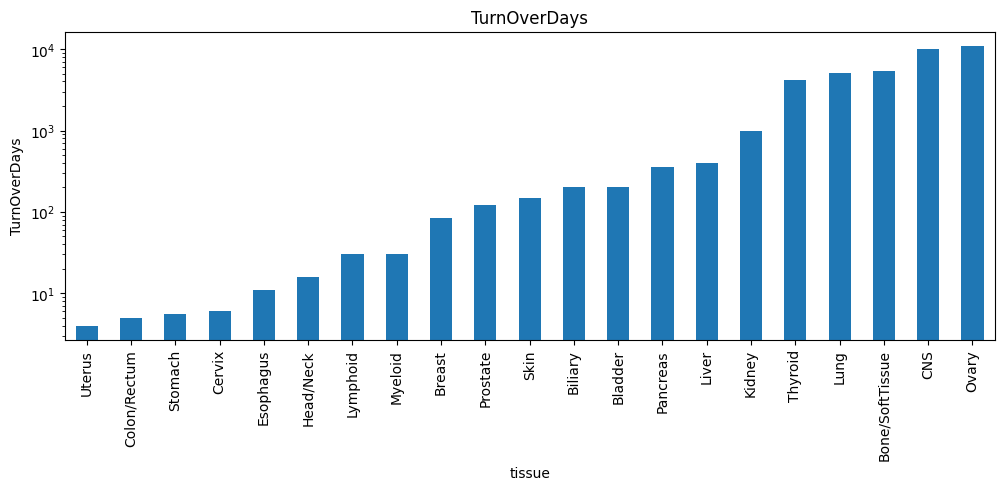

In [77]:
plt.figure(figsize=(12, 4))
plt.title("TurnOverDays")
plt.ylabel("TurnOverDays")
Turn.set_index("tissue").TurnOverDays.plot.bar()
plt.yscale("log")
plt.show()

## Read reference genbank

In [78]:
path_to_gb = "../data/external/NC_012920.1.gb"
Ref = read_genbank_ref(path_to_gb).rename(columns={'gene':"GeneName"})
print(Ref.shape)
Ref.head(4000)

(16569, 9)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon
0,1,G,None,-1,D-loop,NaN,-1,-1,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...
3995,3996,C,ACA,1,CDS,ND1,690,3,AAC
3996,3997,A,CAT,1,CDS,ND1,691,1,ATT
3997,3998,T,ATT,1,CDS,ND1,692,2,ATT
3998,3999,T,TTA,1,CDS,ND1,693,3,ATT


### Derive TBSS for each position, positions within D-loop and Ol will have NA

In [7]:
Ref["TBSS"] = np.nan
Ref["TBSS"].loc[(Ref.Pos > 576) & (Ref.Pos < 5721)] = 16569 - (5721 - Ref.Pos) * 2  # minor arc; L-strand replication origin (locus MT-OLR, 5721 - 5798)
Ref["TBSS"].loc[(Ref.Pos > 5798) & (Ref.Pos < 16024)] = (Ref.Pos - 5798) * 2        # major arc

Ref.to_csv("../data/processed/ref_annot.csv", index=None)

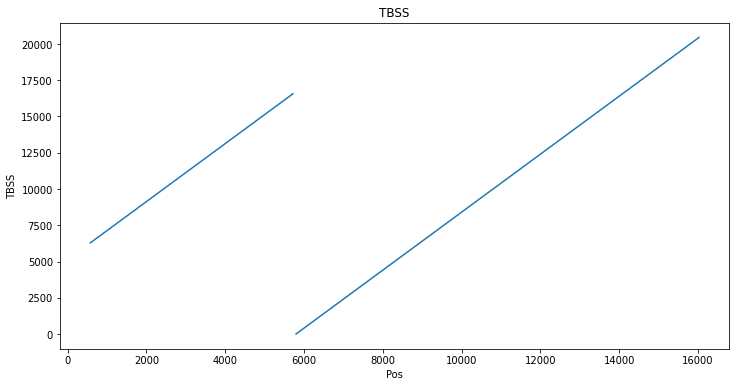

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(Ref.Pos, Ref.TBSS)
plt.title("TBSS")
plt.ylabel("TBSS")
plt.xlabel("Pos")
plt.show()

### Merge mutations and custom annotation from genbank

In [8]:
coda = CodonAnnotation(2)

In [82]:
def get_alt(ser: pd.Series):
    if not isinstance(ser["Codon"], str):
        return None
    codon = list(ser["Codon"])
    ref_nuc, alt_nuc = ser["ref"], ser["var"]
    pic = ser["PosInCodon"] - 1
    assert codon[pic] == ref_nuc, "reference nucleotide is not tha same as in codon"
    codon[pic] = alt_nuc
    alt_codon = "".join(codon)
    return alt_codon
    
mutations = pd.merge(
    ObsAll[["sample", "tissue", "cancer_type", "position", "ref", 
            "var", 'sbs', 'TurnOverDays', 'tumor_var_freq']], 
    Ref, left_on=["position", "ref"], right_on=["Pos", "Nuc"],
)
mutations["AltCodon"] = mutations.apply(get_alt, axis=1)
mutations["Label"] = mutations.apply(
    lambda s: 0 if s.PosInCodon <= 0 else coda.get_mut_type(
        s.Codon, s.AltCodon, s.PosInCodon - 1)[0], axis=1)
mutations["Mut"] = mutations.Context.str.get(0) + "[" + mutations["ref"] + ">" + mutations["var"] + "]" + mutations.Context.str.get(-1)

assert len(mutations[mutations.sbs != mutations.Mut]) == 0, "contexts are not equal"

mutations.drop(["position", "ref", "var", "sbs"], axis=1, inplace=True)
mutations.to_csv("../data/processed/mutations.csv", index=None)
print(mutations.shape)
mutations.head()

(7611, 17)


,sample,tissue,cancer_type,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,AltCodon,Label,Mut
0,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,None,0,T[T>C]G
1,ICGC_0437,Pancreas,PAEN,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,None,0,T[T>C]G
2,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,CTC,2,T[T>C]A
3,096b4f32-10c1-4737-a0dd-cae04c54ee33,Bladder,BLCA,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,0,T[G>A]C
4,OCCAMS-RS-031,Esophagus,ESAD,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,0,T[G>A]C


## Load prepared mutations and reference

In [14]:
mutations = pd.read_csv("../data/processed/mutations.csv")
print(mutations.shape)
mutations.head()

(7611, 16)


,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C


In [16]:
Ref = pd.read_csv("../data/processed/ref_annot.csv")
print(Ref.shape)
Ref.head()

(16569, 10)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
0,1,G,NaN,-1,D-loop,NaN,-1,-1,NaN,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN,NaN


### Describe observed mutations

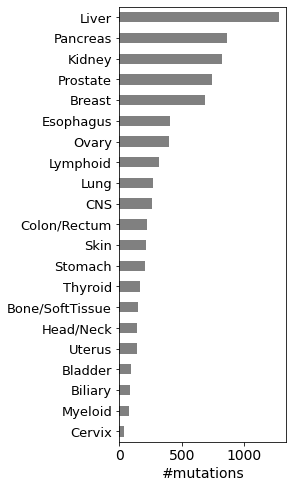

In [17]:
plt.figure(figsize=(3, 8))
mutations.tissue.value_counts(ascending=True).plot.barh(color="gray")
plt.xlabel("#mutations", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.savefig("../figures/cancer_mutations_on_tissues.png", dpi=300, bbox_inches="tight")
plt.show()

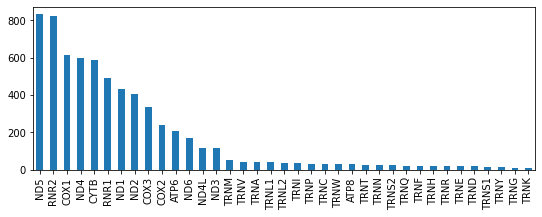

In [18]:
plt.figure(figsize=(9, 3))
mutations.GeneName.value_counts().plot.bar();

In [19]:
mutations.Strand.value_counts()

 1    6209
-1    1359
 0      43
Name: Strand, dtype: int64

In [20]:
mutations.Label.value_counts()

 0    6488
 2     462
 1     373
-1     278
-3      10
Name: Label, dtype: int64

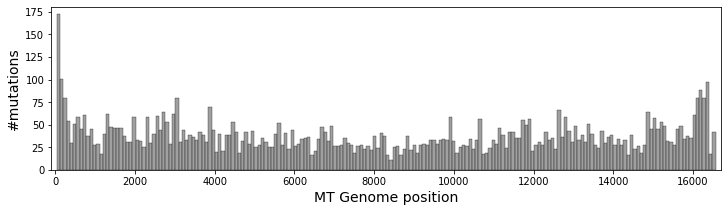

In [21]:
plt.figure(figsize=(12, 3))
# plt.title("Distribution of mutaions on genome")
plt.xlabel("MT Genome position", fontsize=14)
plt.ylabel("#mutations", fontsize=14)
sns.histplot(mutations.Pos, bins=200, color="gray")
plt.xlim(-100, 16700)
plt.savefig("../figures/cancer_mutations_on_genome.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
ObsAll.is_nonsense.value_counts()

0    7330
1     281
Name: is_nonsense, dtype: int64

In [23]:
mutations_summary(mutations, gene_col="GeneName")

,non-syn,syn,syn4f,Stop gain,Stop to stop
GeneName,,,,,
ATP6,150,51,31,5,0
ATP8,11,13,2,5,0
COX1,428,124,72,59,0
COX2,184,45,28,9,1
COX3,261,47,22,30,0
CYTB,450,83,49,50,3
ND1,337,74,44,17,3
ND2,285,90,56,27,3
ND3,83,29,7,4,0


## For asymmetry

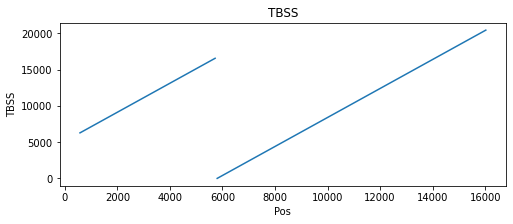

In [30]:
plt.figure(figsize=(8, 3))
plt.plot(Ref.Pos, Ref.TBSS)
plt.title("TBSS")
plt.ylabel("TBSS")
plt.xlabel("Pos")
plt.show()

In [50]:
major_arc_min_pos = 5800
major_arc_max_pos = 16000

region_size = 5000
print(f"Low TSSS region: {major_arc_min_pos}-{major_arc_min_pos+region_size}\nLow TSSS region: {major_arc_max_pos-region_size}-{major_arc_max_pos}\n")
print("Please check that they are not intersect!!")

Low TSSS region: 5800-10800
Low TSSS region: 11000-16000

Please check that they are not intersect!!


**Prepare OBS**

In [130]:
obs_low_tsss_all = mutations[
    (mutations.Type != "D-loop") &
    (mutations.Pos > major_arc_min_pos) &
    (mutations.Pos < major_arc_min_pos+region_size) & 
    (mutations.Strand == 1)
]
obs_high_tsss_all = mutations[
    (mutations.Type != "D-loop") &
    (mutations.Pos > major_arc_max_pos-region_size) &
    (mutations.Pos < major_arc_max_pos) &
    (mutations.Strand == 1)
]

obs_low_tsss_syn = obs_low_tsss_all[obs_low_tsss_all.Label >= 1]
obs_high_tsss_syn = obs_high_tsss_all[obs_high_tsss_all.Label >= 1]

print(obs_low_tsss_all.shape, obs_high_tsss_all.shape)
print(obs_low_tsss_syn.shape, obs_high_tsss_syn.shape)

(1724, 16) (2048, 16)
(338, 16) (321, 16)


In [143]:
print(
    obs_low_tsss_all.TBSS.mean().round(),
    obs_low_tsss_syn.TBSS.mean().round(),
    obs_high_tsss_all.TBSS.mean().round(),
    obs_high_tsss_syn.TBSS.mean().round(),
)

5073.0 4956.0 15170.0 14981.0


**Prepare EXP**

In [126]:
cur_ref = Ref[(Ref.Type != "D-loop")].assign(AltNuc="ACGT")
cur_ref["AltNuc"] = cur_ref.AltNuc.apply(list)
cur_ref["AltCodon"] = cur_ref.apply(lambda x: coda.get_syn_codons(x.Codon, x.PosInCodon-1) if x.PosInCodon > -1 else [], axis=1)

ref_low_tsss = cur_ref[
    (cur_ref.Pos > major_arc_min_pos) &
    (cur_ref.Pos < major_arc_min_pos+region_size) & 
    (cur_ref.Strand == 1)
]
ref_high_tsss = cur_ref[
    (cur_ref.Pos > major_arc_max_pos-region_size) &
    (cur_ref.Pos < major_arc_max_pos) &
    (cur_ref.Strand == 1)
]

In [131]:
exp_low_tsss_all = ref_low_tsss.explode("AltNuc")
exp_low_tsss_all = exp_low_tsss_all[exp_low_tsss_all.Nuc != exp_low_tsss_all.AltNuc]
exp_low_tsss_all["Sbs12"] = exp_low_tsss_all.Nuc + ">" + exp_low_tsss_all.AltNuc
exp_low_tsss_all["Sbs192"] = exp_low_tsss_all.Context.str.get(0) + "[" + exp_low_tsss_all["Sbs12"] + "]" + exp_low_tsss_all.Context.str.get(-1)

exp_low_tsss_syn = ref_low_tsss.explode("AltCodon").dropna(subset="AltCodon")
exp_low_tsss_syn["Sbs12"] = exp_low_tsss_syn.Nuc + ">" + exp_low_tsss_syn.apply(lambda x: x.AltCodon[x.PosInCodon-1], axis=1)
exp_low_tsss_syn["Sbs192"] = exp_low_tsss_syn.Context.str.get(0) + "[" + exp_low_tsss_syn["Sbs12"] + "]" + exp_low_tsss_syn.Context.str.get(-1)


exp_high_tsss_all = ref_high_tsss.explode("AltNuc")
exp_high_tsss_all = exp_high_tsss_all[exp_high_tsss_all.Nuc != exp_high_tsss_all.AltNuc]
exp_high_tsss_all["Sbs12"] = exp_high_tsss_all.Nuc + ">" + exp_high_tsss_all.AltNuc
exp_high_tsss_all["Sbs192"] = exp_high_tsss_all.Context.str.get(0) + "[" + exp_high_tsss_all["Sbs12"] + "]" + exp_high_tsss_all.Context.str.get(-1)

exp_high_tsss_syn = ref_high_tsss.explode("AltCodon").dropna(subset="AltCodon")
exp_high_tsss_syn["Sbs12"] = exp_high_tsss_syn.Nuc + ">" + exp_high_tsss_syn.apply(lambda x: x.AltCodon[x.PosInCodon-1], axis=1)
exp_high_tsss_syn["Sbs192"] = exp_high_tsss_syn.Context.str.get(0) + "[" + exp_high_tsss_syn["Sbs12"] + "]" + exp_high_tsss_syn.Context.str.get(-1)


exp_low_tsss_all_freqs = exp_low_tsss_all.Sbs192.value_counts().to_dict()
exp_low_tsss_syn_freqs = exp_low_tsss_syn.Sbs192.value_counts().to_dict()
exp_high_tsss_all_freqs = exp_high_tsss_all.Sbs192.value_counts().to_dict()
exp_high_tsss_syn_freqs = exp_high_tsss_syn.Sbs192.value_counts().to_dict()

print(exp_low_tsss_all.shape)
print(exp_low_tsss_syn.shape)
print(exp_high_tsss_all.shape)
print(exp_high_tsss_syn.shape)

(14394, 14)
(3271, 14)
(13065, 14)
(2976, 14)


In [144]:
print(
    exp_low_tsss_all.TBSS.mean().round(),
    exp_low_tsss_syn.TBSS.mean().round(),
    exp_high_tsss_all.TBSS.mean().round(),
    exp_high_tsss_syn.TBSS.mean().round(),
)

5134.0 5067.0 15091.0 15088.0


In [135]:
ms_low_tsss_all = calculate_mutspec(obs_low_tsss_all, exp_low_tsss_all_freqs, use_context=True)
ms_low_tsss_syn = calculate_mutspec(obs_low_tsss_syn, exp_low_tsss_syn_freqs, use_context=True)
ms_high_tsss_all = calculate_mutspec(obs_high_tsss_all, exp_high_tsss_all_freqs, use_context=True)
ms_high_tsss_syn = calculate_mutspec(obs_high_tsss_syn, exp_high_tsss_syn_freqs, use_context=True)

In [138]:
ms_low_tsss_all.to_csv("../data/asymmetry/ms_low_tsss_all.csv", index=False)
ms_low_tsss_syn.to_csv("../data/asymmetry/ms_low_tsss_syn.csv", index=False)
ms_high_tsss_all.to_csv("../data/asymmetry/ms_high_tsss_all.csv", index=False)
ms_high_tsss_syn.to_csv("../data/asymmetry/ms_high_tsss_syn.csv", index=False)

In [139]:
print(ms_low_tsss_all.MutSpec.isna().sum(),
    ms_low_tsss_syn.MutSpec.isna().sum(),
    ms_high_tsss_all.MutSpec.isna().sum(),
    ms_high_tsss_syn.MutSpec.isna().sum()
)

0 0 0 0


In [140]:
print((ms_low_tsss_all.MutSpec == 0).sum(),
    (ms_low_tsss_syn.MutSpec == 0).sum(),
    (ms_high_tsss_all.MutSpec == 0).sum(),
    (ms_high_tsss_syn.MutSpec == 0).sum()
)

75 121 70 122


## Frequencies counting

In [6]:
ProtRef = Ref[(Ref.Type == "CDS") & (Ref.Strand == 1)]

In [7]:
exp_muts12 = dict()
exp_muts192 = dict()
for gene, gtable in ProtRef[ProtRef.Codon.str.len() == 3].groupby("GeneName"):
    assert np.all(gtable.PosInGene == np.arange(1, gtable.shape[0] + 1))
    seq = gtable.Nuc.values
    gene_exp_muts12, gene_exp_muts192 = coda.collect_exp_mut_freqs(seq)
    for lbl in gene_exp_muts12:
        if lbl not in exp_muts12:
            exp_muts12[lbl] = defaultdict(int)
            exp_muts192[lbl] = defaultdict(int)

        for sbs, _cnt in gene_exp_muts12[lbl].items():
            exp_muts12[lbl][sbs] += _cnt
        for sbs, _cnt in gene_exp_muts192[lbl].items():
            exp_muts192[lbl][sbs] += _cnt

        if gene == "CYTB" and lbl == "all":
            exp_muts12[lbl + gene] = gene_exp_muts12[lbl]
            exp_muts192[lbl + gene] = gene_exp_muts192[lbl]

for lbl in ["D-loop", "rRNA", "tRNA"]:
    f1, f2 = coda.collect_exp_mut_freqs(Ref[Ref.Type == lbl]["Nuc"].values, ["all"])
    exp_muts12[lbl], exp_muts192[lbl] = f1["all"], f2["all"]

lbl = "ExDloop"
f1, f2 = coda.collect_exp_mut_freqs(Ref[(~Ref.Type.isin(["D-loop", "misc_feature"]))]["Nuc"].values, ["all"])
exp_muts12[lbl], exp_muts192[lbl] = f1["all"], f2["all"]

In [13]:
with open("../data/processed/expected_sbs192.json", "w") as handle:
    json.dump(exp_muts192, handle)
with open("../data/processed/expected_sbs12.json", "w") as handle:
    json.dump(exp_muts12, handle)

In [8]:
pd.DataFrame(exp_muts12).sort_index()

,ff,syn,all,allCYTB,D-loop,rRNA,tRNA,ExDloop
A>C,766,766,3148,325,339,861,527,4785
A>G,766,1308,3148,325,339,861,527,4785
A>T,766,766,3148,325,339,861,527,4785
C>A,817,817,3579,390,371,650,353,4810
C>G,817,817,3579,390,371,650,353,4810
C>T,817,1872,3579,390,371,650,353,4810
G>A,96,178,1294,137,150,451,217,2015
G>C,96,96,1294,137,150,451,217,2015
G>T,96,96,1294,137,150,451,217,2015
T>A,261,261,2758,286,260,548,405,3834


In [9]:
pd.DataFrame(exp_muts192).sort_index()

,ff,syn,all,allCYTB,D-loop,rRNA,tRNA,ExDloop
A[A>C]A,NaN,NaN,265,25.0,30,113,78.0,494
A[A>C]C,NaN,NaN,304,27.0,32,84,51.0,463
A[A>C]G,NaN,NaN,81,6.0,13,69,40.0,196
A[A>C]T,NaN,NaN,233,32.0,21,50,41.0,355
A[A>G]A,NaN,78.0,265,25.0,30,113,78.0,494
...,...,...,...,...,...,...,...,...
T[T>C]T,13.0,47.0,153,11.0,20,32,44.0,231
T[T>G]A,34.0,34.0,192,19.0,18,56,52.0,311
T[T>G]C,28.0,28.0,232,28.0,15,26,27.0,293
T[T>G]G,11.0,11.0,65,10.0,12,22,14.0,104


### Explorary features analysis

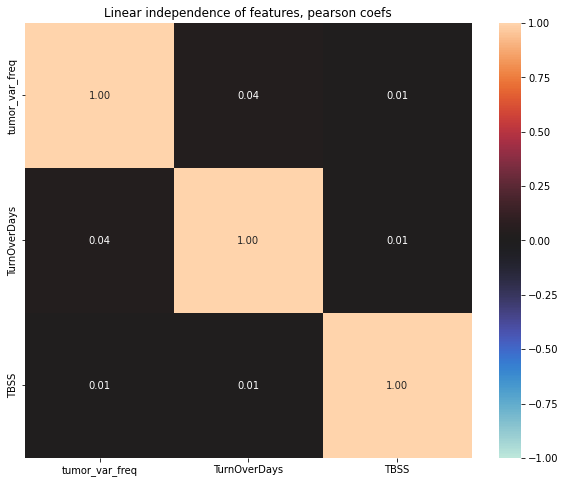

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(mutations[["tumor_var_freq", "TurnOverDays", "TBSS"]].corr(), annot=True, fmt=".2f", center=0, vmin=-1)
plt.title("Linear independence of features, pearson coefs")
plt.show()

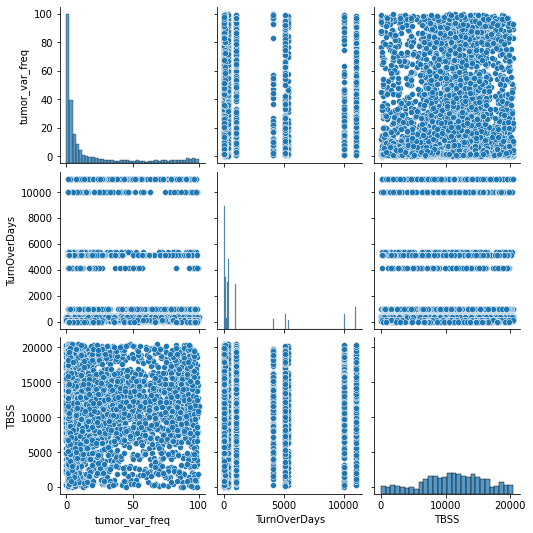

In [33]:
# Full independence of features
sns.pairplot(mutations[["tumor_var_freq", "TurnOverDays", "TBSS"]]);

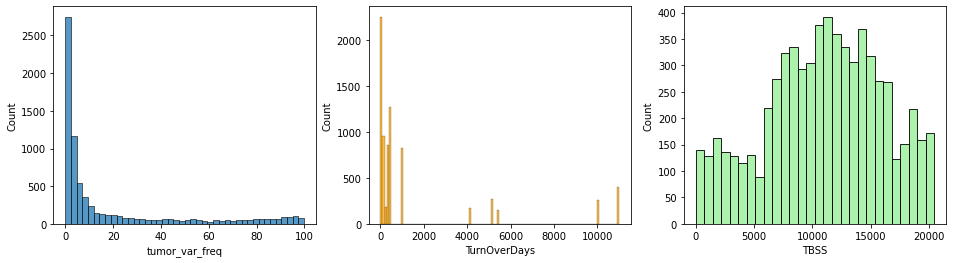

In [38]:
plt.figure(figsize=(16, 4))
plt.subplot(131)
sns.histplot(mutations["tumor_var_freq"])
plt.subplot(132)
sns.histplot(mutations["TurnOverDays"], color="orange")
plt.subplot(133)
sns.histplot(mutations["TBSS"], color="lightgreen")
plt.show()

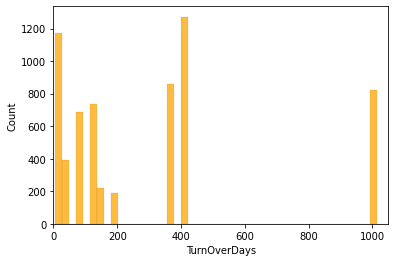

In [70]:
sns.histplot(mutations["TurnOverDays"], color="orange", bins=500, cumulative=False)
plt.xlim(0, 1050);

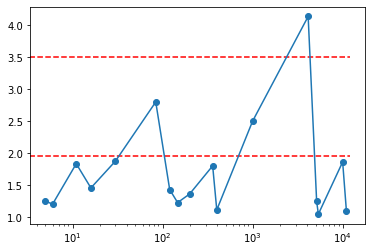

In [260]:
a = sorted(mutations.TurnOverDays.astype(int).unique())
shifts = [a[i + 1] / a[i] for i in range(len(a) - 1)]

plt.plot(a[1:], shifts, "o-")
plt.hlines(1.95, 0, 12000, "r", linestyle="--", )
plt.hlines(3.5, 0, 12000, "r", linestyle="--", )
plt.xscale("log")

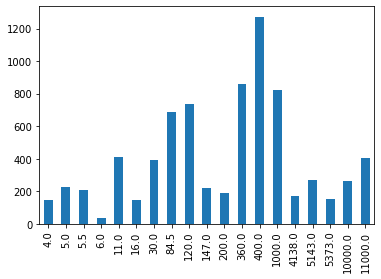

In [189]:
mutations.TurnOverDays.value_counts().sort_index().plot.bar();